In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [15]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

cecilianordberg_la_segmentation_path = kagglehub.dataset_download('cecilianordberg/la-segmentation')
cecilianordberg_scripts_other_default_1_path = kagglehub.model_download('cecilianordberg/scripts/Other/default/1')

print('Data source import complete.')


Data source import complete.


## Imports

In [4]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
from PIL import Image
from IPython.display import display, Image as IPImage

In [5]:
!pip install nibabel
import nibabel as nib

## Dataset + preprocessing / augmentation

Rotating, Gaussian blur, normalization per patient (over full volume), crop image to remove deadspace
Flipping doesn not have a great effect on tumor segmentation

**Tips for training 3d-UNet:**
* Before training make sure that the data you want to train is normalized and resized for the model.
* Main purpose of normalization is to make computation efficient by reducing values between 0 to 1 as well as removing noise in data.
* Images used for medical image segmentation are high-resolution three-dimensional (3D) images. To reduce the memory usage on GPU’s, we can use a patch-based method, which divides a large image into small patches and trains the models with these small patches.

**TODO:**
* Bestäm ett rimligt område för crop baserat på visualisering av bilder

In [6]:
import sys

scripts_dir = '/kaggle/input/scripts/other/default/1'
#print(os.listdir(scripts_dir)) - Files in dir
sys.path.append(scripts_dir)

In [19]:
import glob

# Load images in directories
data_dir = os.path.join(cecilianordberg_la_segmentation_path, 'Task02_Heart')

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii")))
train_data_dict = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

val_images = sorted(glob.glob(os.path.join(data_dir, "imagesVl", "*.nii")))
val_labels = sorted(glob.glob(os.path.join(data_dir, "labelsVl", "*.nii")))
val_data_dict = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images, val_labels)]

# Display first image and label in train dict
train_data_dict[15]

{'image': '/root/.cache/kagglehub/datasets/cecilianordberg/la-segmentation/versions/1/Task02_Heart/imagesTr/la_023.nii',
 'label': '/root/.cache/kagglehub/datasets/cecilianordberg/la-segmentation/versions/1/Task02_Heart/labelsTr/la_023.nii'}

### Transforms

In [8]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.8 MB/s eta 0:00:00


In [21]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 14.8 MB/s eta 0:00:00


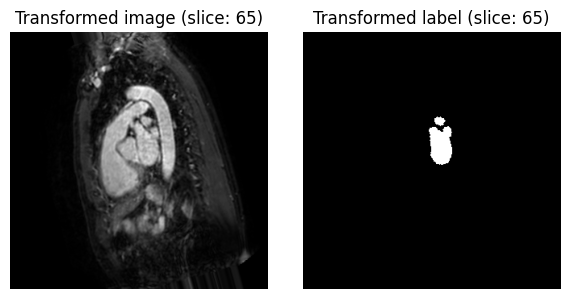

In [22]:
# TODO, take slice index as input
import SimpleITK as sitk
from monai.transforms import Rotated, RandRotated, RandZoomd, RandAffined, RandGaussianNoised, RandGaussianSmoothd

def visualize_transform(data_dict, img_idx=0, transform=None):
    image, label = data_dict[img_idx]["image"], data_dict[img_idx]["label"]

    image_array = sitk.GetArrayFromImage(sitk.ReadImage(image))
    label_array = sitk.GetArrayFromImage(sitk.ReadImage(label))

    data = {"image": image_array, "label": label_array}

    # Apply transform if provided
    if transform:
        transformed = transform(data)
        image_array, label_array = transformed["image"], transformed["label"]

    mid_slice = image_array.shape[0] // 2
    slice_img = image_array[mid_slice, :, :]
    slice_label = label_array[mid_slice, :, :]
    flipped_slice_img = np.flip(slice_img, axis=(0, 1))
    flipped_slice_label = np.flip(slice_label, axis=(0, 1))

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(flipped_slice_img, cmap='gray')
    axes[0].set_title(f'Transformed image (slice: {mid_slice})')
    axes[0].axis('off')

    axes[1].imshow(flipped_slice_label, cmap='gray')
    axes[1].set_title(f'Transformed label (slice: {mid_slice})')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# TODO - FIX multiple transforms
#transform = Rotated(keys=["image","label"], angle=0.2, mode=["bilinear", "nearest"])
transform = RandRotated(keys=["image","label"], prob=0.4, range_x=[-0.3, 0.3], mode=["bilinear", "nearest"])
#transform = RandZoomd(keys=["image","label"], prob=0.4, min_zoom=1.1, max_zoom=1.5, mode=["area", "nearest"])
#transform =RandAffined(keys=["image","label"], prob=0.5, shear_range=(0.4,0.4), mode=["bilinear", "nearest"],padding_mode="zeros")
#transform = RandGaussianNoised(keys=["image"], prob=0.9, mean=0, std=0.1)
#transform = RandGaussianSmoothd(keys="image",prob=1.0, sigma_x=(0,3))
visualize_transform(train_data_dict, img_idx=0, transform=transform)

### Dataset and loader

In [23]:
import torch
from glob import glob
from torch.utils.data import Dataset
import SimpleITK as sitk
import numpy as np

class TrainDataset(Dataset):
    """
    require_target = True => all returned patches contain atleast some of the target
    preoad_all_images = True => all images are loaded into memory at the start
    """

    def __init__(self, data_dir, labels_dir, patch_size, require_target=False,transform=None, preload_all_images=True, num_patches_per_image=1):
        self.patch_size = patch_size
        self.transform = transform
        self.require_target = require_target

        self.data_paths = sorted(glob(data_dir + '/*.nii'))
        self.label_paths = sorted(glob(labels_dir + '/*.nii'))

        self.preload_all_images = preload_all_images
        if preload_all_images:
            self.data = {path_: sitk.GetArrayFromImage(sitk.ReadImage(path_)).astype('float32') for path_ in self.data_paths}
            self.labels = {path_: sitk.GetArrayFromImage(sitk.ReadImage(path_)).astype('int64') for path_ in self.label_paths}

        self.num_patches_per_image = num_patches_per_image

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        if self.preload_all_images:
            image_np = self.data[self.data_paths[idx]]
            label_np = self.labels[self.label_paths[idx]]
        else:
            image  = sitk.ReadImage(self.data_paths[idx])
            label = sitk.ReadImage(self.label_paths[idx])

            image_np = sitk.GetArrayFromImage(image).astype('float32')
            label_np = sitk.GetArrayFromImage(label).astype('int64')

        patches = []
        labels = []
        for _ in range(self.num_patches_per_image):
            if self.require_target:
                image_patch, label_patch = self.random_crop_3d_target(image_np, label_np, self.patch_size)
            else:
                image_patch, label_patch = self.random_crop_3d(image_np, label_np, self.patch_size)

            if self.transform:
                array_data = {"image_patch": image_patch, "label_patch": label_patch}
                transformed = self.transform(array_data)
                image_patch, label_patch = transformed["image_patch"], transformed["label_patch"]

            image_tensor = torch.as_tensor(image_patch, dtype=torch.float32).unsqueeze(0)
            label_tensor = torch.as_tensor(label_patch, dtype=torch.float32)
            patches.append(image_tensor)
            labels.append(label_tensor)

        return torch.stack(patches, dim=0), torch.stack(labels, dim=0)

    def random_crop_3d(self, image, label, patch_size):
        z, y, x = image.shape
        pz, py, px = patch_size
        sz = torch.randint(0, z - pz, (1,)).item()
        sy = torch.randint(0, y - py, (1,)).item()
        sx = torch.randint(0, x - px, (1,)).item()
        return image[sz:sz+pz, sy:sy+py, sx:sx+px], label[sz:sz+pz, sy:sy+py, sx:sx+px]

    def random_crop_3d_target(self, image, label, patch_size):
        z, y, x = image.shape
        pz, py, px = patch_size

        ones_indices = np.argwhere(label)
        z_min, y_min, x_min = ones_indices.min(axis=0)
        z_max, y_max, x_max = ones_indices.max(axis=0)

        z_patch_min, y_patch_min, x_patch_min = max(0, z_min - pz), max(0, y_min - py), max(0, x_min - px)
        z_patch_max, y_patch_max, x_patch_max = min(z - pz, z_max), min(y - py, y_max), min(x - px, x_max)

        sz = torch.randint(z_patch_min, z_patch_max + 1, (1,)).item()
        sy = torch.randint(y_patch_min, y_patch_max + 1, (1,)).item()
        sx = torch.randint(x_patch_min, x_patch_max + 1, (1,)).item()

        return image[sz:sz+pz, sy:sy+py, sx:sx+px], label[sz:sz+pz, sy:sy+py, sx:sx+px]


class TestDataset(Dataset):
    """
    Test dataset loads the entire image
    """
    def __init__(self, data_dir, labels_dir=None, transform=None):
        self.transform = transform

        self.data_paths = sorted(glob(data_dir + '/*'))
        self.label_paths = sorted(glob(labels_dir + '/*')) if labels_dir is not None else None

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index):
        image = sitk.ReadImage(self.data_paths[index])
        image_np = sitk.GetArrayFromImage(image).astype('float32')

        if self.label_paths is not None:
            label = sitk.ReadImage(self.label_paths[index])
            label_np = sitk.GetArrayFromImage(label).astype('int64')
        else:
            label_np = None

        #if self.transform:
        #    image_np = self.transform(image_np)

        image_tensor = torch.tensor(image_np, dtype=torch.float32).unsqueeze(0)

        if label_np is not None:
            label_tensor = torch.tensor(label_np, dtype=torch.int64)
            return image_tensor, label_tensor
        else:
            return image_tensor

In [34]:
patch_size = (64, 128, 128)
transform = RandRotated(keys=["image","label"], prob=0.5, range_x=[-0.3, 0.3], mode=["bilinear", "nearest"])
#transform =RandAffined(keys=["image_patch","label_patch"], prob=1.0, shear_range=(0.3,0.3), mode=["bilinear", "nearest"],padding_mode="zeros")
#transform = RandZoomd(keys=["image_patch","label_patch"], prob=0.4, min_zoom=1.1, max_zoom=1.5, mode=["area", "nearest"])
transform = None

train_image_path = os.path.join(cecilianordberg_la_segmentation_path, 'Task02_Heart/imagesTr')
train_label_path = os.path.join(cecilianordberg_la_segmentation_path, 'Task02_Heart/labelsTr')
val_image_path = os.path.join(cecilianordberg_la_segmentation_path, 'Task02_Heart/imagesVl')
val_label_path = os.path.join(cecilianordberg_la_segmentation_path, 'Task02_Heart/labelsVl')

train_dataset = TrainDataset(train_image_path, train_label_path, patch_size, require_target=True, transform=transform, preload_all_images=True, num_patches_per_image=2)
val_dataset = TestDataset(val_image_path, val_label_path)

batch_size = 2
# The effective batch size will be batch_size * num_patches_per_image
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

## Utils

In [26]:
import torch.nn as nn
import torch

def dice_coefficient(pred, target, smooth=1.):
    pred = pred > 0.5  # Thresholding to get binary predictions
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def soft_dice_coefficient(pred, target, smooth=1.):
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def soft_dice_loss(pred, target, smooth=1.):
    return 1 - soft_dice_coefficient(pred, target, smooth)

def soft_iou(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def iou(pred, target, smooth=1e-6):
    pred = pred > 0.5  # Thresholding to get binary predictions
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

class CombinedLoss(nn.Module):
    """
    Expects logit inputs
    """

    def __init__(self, smooth=1):
        super(CombinedLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.smooth = smooth

    def forward(self, outputs, targets):
        ce_loss = self.bce_loss(outputs, targets)
        dice = soft_dice_loss(torch.sigmoid(outputs), targets, self.smooth)
        return ce_loss + dice

## Training of model

In [27]:
import sys
from monai.networks.nets import UNETR

In [32]:
from collections import defaultdict
from time import time
import torch
import torch.nn.functional as F

def train_epoch(model, optimizer, loss_fn, train_loader, scheduler, device):
    model.train()
    train_loss = AccumulatingMetric()
    train_iou = AccumulatingMetric()
    train_dice = AccumulatingMetric()
    for batch in train_loader:
        input, target = batch
        # Concatenate the patches along the batch dimension
        input = input.view(-1, *input.shape[2:])
        target = target.view(-1, *target.shape[2:])

        input, target = input.to(device), target.to(device).float()
        optimizer.zero_grad()
        pred_logits = model(input)
        pred_logits = pred_logits.squeeze(1)
        loss = loss_fn(pred_logits, target)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        pred = torch.sigmoid(pred_logits)
        train_loss.add(loss.item())
        train_iou.add(iou(pred, target).cpu().item())
        train_dice.add(dice_coefficient(pred, target).cpu().item())

    return train_loss.avg(), train_iou.avg(), train_dice.avg()

def validate(model, loss_fn, val_loader, device, patch_size):
    model.eval()
    validation_loss = AccumulatingMetric()
    validation_iou = AccumulatingMetric()
    validation_dice = AccumulatingMetric()

    for batch in val_loader:
        # Here I need to separate the input into patches and then merge them after they have all been analyzed. Should I do this with overlap? Yes I should.
        input, target = batch
        input, target = input.to(device), target.to(device).float()
        with torch.no_grad():
            pred_logits = patched_forward(model, input, patch_size, device)
        pred_logits = pred_logits.squeeze(1)
        pred = torch.sigmoid(pred_logits)
        # Calculate the loss, iou and dice coefficient
        loss = loss_fn(pred_logits, target)

        validation_loss.add(loss.item())
        validation_iou.add(iou(pred, target).cpu().item())
        validation_dice.add(dice_coefficient(pred, target).cpu().item())

    return validation_loss.avg(), validation_iou.avg(), validation_dice.avg()

def patched_forward(model, input, patch_size, device, overlap=0.5):
    # This function will take an input image and split it into patches, then run the model on each patch and merge the results.
    batch_size, channels, z, y, x = input.shape
    pz, py, px = patch_size
    stride_z, stride_y, stride_x = int(pz * (1 - overlap)), int(py * (1 - overlap)), int(px * (1 - overlap))

    # Calculate needed padding
    pad_z = (pz - z % pz) if z % pz != 0 else 0
    pad_y = (py - y % py) if y % py != 0 else 0
    pad_x = (px - x % px) if x % px != 0 else 0
    input_padded = F.pad(input, (0, pad_x, 0, pad_y, 0, pad_z))
    padded_z, padded_y, padded_x = input_padded.shape[2:]

    output = torch.zeros((batch_size, channels, padded_z, padded_y, padded_x)).to(device)
    weight_map = torch.zeros((batch_size, channels, padded_z, padded_y, padded_x)).to(device)

    for z_start in range(0, padded_z - pz + 1, stride_z):
        for y_start in range(0, padded_y - py + 1, stride_y):
            for x_start in range(0, padded_x - px + 1, stride_x):
                z_end, y_end, x_end = z_start + pz, y_start + py, x_start + px

                patch = input_padded[:, :, z_start:z_end, y_start:y_end, x_start:x_end]
                patch_output = model(patch)
                # Add the output of the patch to the combined output
                output[:, :, z_start:z_end, y_start:y_end, x_start:x_end] += patch_output

                # Keep track of how many values has been added to each region so that we can average them later
                weight_map[:, :, z_start:z_end, y_start:y_end, x_start:x_end] += 1

    # Avoid division by zero in case some areas are not covered by patches
    weight_map = torch.where(weight_map == 0, torch.ones_like(weight_map), weight_map)

    output /= weight_map

    # Remove padding
    output = output[:, :, :z, :y, :x]
    return output


def train(model, optimizer, loss_fn, train_loader, val_loader, scheduler, device, epochs, patch_size, validation_freq=1):
    print(f"Starting training on device {device}...")
    model.to(device)
    train_metrics = defaultdict(list)
    val_metrics = defaultdict(list)

    best_val_loss = float('inf')  # To store the best validation loss
    best_model_state = None       # To store the best model state

    for epoch in range(epochs):
        start_time = time()
        # Training step
        train_loss, train_iou, train_dice = train_epoch(model, optimizer, loss_fn, train_loader, scheduler, device)
        train_metrics["loss"].append(train_loss)
        train_metrics["iou"].append(train_iou)
        train_metrics["dice"].append(train_dice)
        print(f"Epoch {epoch + 1} of {epochs} took {time() - start_time:.2f}s | Training: loss={train_loss:.4f}, iou={train_iou:.4f}, dice={train_dice:.4f}")

        # Validation step
        if epoch % validation_freq == validation_freq - 1 or epoch == epochs - 1:
            val_loss, val_iou, val_dice = validate(model, loss_fn, val_loader, device, patch_size)
            val_metrics["loss"].append(val_loss)
            val_metrics["iou"].append(val_iou)
            val_metrics["dice"].append(val_dice)
            print(f"Validation: loss={val_loss:.4f}, iou={val_iou:.4f}, dice={val_dice:.4f}")

            # Save the best model based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()  # Save the model state
                print(f"New best model found with validation loss {val_loss:.4f}, saving model...")

    model.load_state_dict(best_model_state)
    return model, train_metrics, val_metrics


class AccumulatingMetric:
    """Accumulate samples of a metric and automatically keep track of the number of samples."""

    def __init__(self):
        self.metric = 0.0
        self.counter = 0

    def add(self, value):
        self.metric += value
        self.counter += 1

    def avg(self):
        return self.metric / (self.counter)

In [35]:
model = UNETR(in_channels=1, out_channels=1, img_size=(64 , 128 , 128))

loss_fn = CombinedLoss(smooth=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 200
validation_freq = 20

results_train = train(model, optimizer, loss_fn, train_loader, val_loader, None, device, epochs, patch_size=patch_size, validation_freq=validation_freq)

Starting training on device cuda...
Epoch 1 of 200 took 22.76s | Training: loss=1.6187, iou=0.0348, dice=0.0669
Epoch 2 of 200 took 22.23s | Training: loss=1.5427, iou=0.0449, dice=0.0855
Epoch 3 of 200 took 23.86s | Training: loss=1.4876, iou=0.0507, dice=0.0963
Epoch 4 of 200 took 25.37s | Training: loss=1.4624, iou=0.0587, dice=0.1104
Epoch 5 of 200 took 23.38s | Training: loss=1.4358, iou=0.0899, dice=0.1644
Epoch 6 of 200 took 23.19s | Training: loss=1.4223, iou=0.0972, dice=0.1761
Epoch 7 of 200 took 23.42s | Training: loss=1.4051, iou=0.1485, dice=0.2583
Epoch 8 of 200 took 23.56s | Training: loss=1.4052, iou=0.1493, dice=0.2585
Epoch 9 of 200 took 23.48s | Training: loss=1.3926, iou=0.1609, dice=0.2716
Epoch 10 of 200 took 23.37s | Training: loss=1.3877, iou=0.1597, dice=0.2706
Epoch 11 of 200 took 23.44s | Training: loss=1.3806, iou=0.1402, dice=0.2439
Epoch 12 of 200 took 23.43s | Training: loss=1.3623, iou=0.1927, dice=0.3206
Epoch 13 of 200 took 23.54s | Training: loss=1.36

In [36]:
best_model, results_train, results_val = results_train

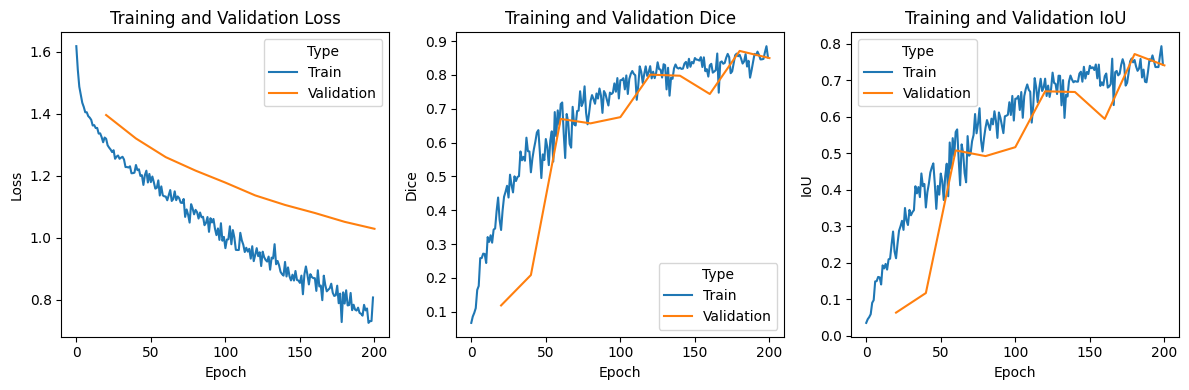

In [37]:
import pandas as pd
import seaborn as sns

# Create DataFrames for easier plotting with Seaborn
df_train_loss = pd.DataFrame({'Epoch': range(len(results_train['loss'])), 'Value': results_train['loss'], 'Metric': 'Loss', 'Type': 'Train'})
df_val_loss = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['loss']))], 'Value': results_val['loss'], 'Metric': 'Loss', 'Type': 'Validation'})

df_train_dice = pd.DataFrame({'Epoch': range(len(results_train['dice'])), 'Value': results_train['dice'], 'Metric': 'Dice', 'Type': 'Train'})
df_val_dice = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['dice']))], 'Value': results_val['dice'], 'Metric': 'Dice', 'Type': 'Validation'})

df_train_iou = pd.DataFrame({'Epoch': range(len(results_train['iou'])), 'Value': results_train['iou'], 'Metric': 'IoU', 'Type': 'Train'})
df_val_iou = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['iou']))], 'Value': results_val['iou'], 'Metric': 'IoU', 'Type': 'Validation'})

# Combine the DataFrames
df = pd.concat([df_train_loss, df_val_loss, df_train_dice, df_val_dice, df_train_iou, df_val_iou])

# Plot using Seaborn
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.lineplot(data=df[df['Metric'] == 'Loss'], x='Epoch', y='Value', hue='Type', ax=axs[0])
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

sns.lineplot(data=df[df['Metric'] == 'Dice'], x='Epoch', y='Value', hue='Type', ax=axs[1])
axs[1].set_title('Training and Validation Dice')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Dice')

sns.lineplot(data=df[df['Metric'] == 'IoU'], x='Epoch', y='Value', hue='Type', ax=axs[2])
axs[2].set_title('Training and Validation IoU')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('IoU')

plt.tight_layout()
plt.show()

In [38]:
torch.save(best_model.state_dict(), 'cuboid_unetr200epochs.pth')
import joblib

joblib.dump(best_model, 'cuboid_unetr200epochs.pkl')

['cuboid_unetr200epochs.pkl']

## Evaluation of model

In [39]:
image, label = val_dataset[0]
image = image.unsqueeze(0)
image = image.to(device)
with torch.no_grad():
    pred_logits = patched_forward(best_model, image, patch_size, 'cuda')
pred = torch.sigmoid(pred_logits)
pred = pred.squeeze(0, 1)
image = image.squeeze(0, 1)

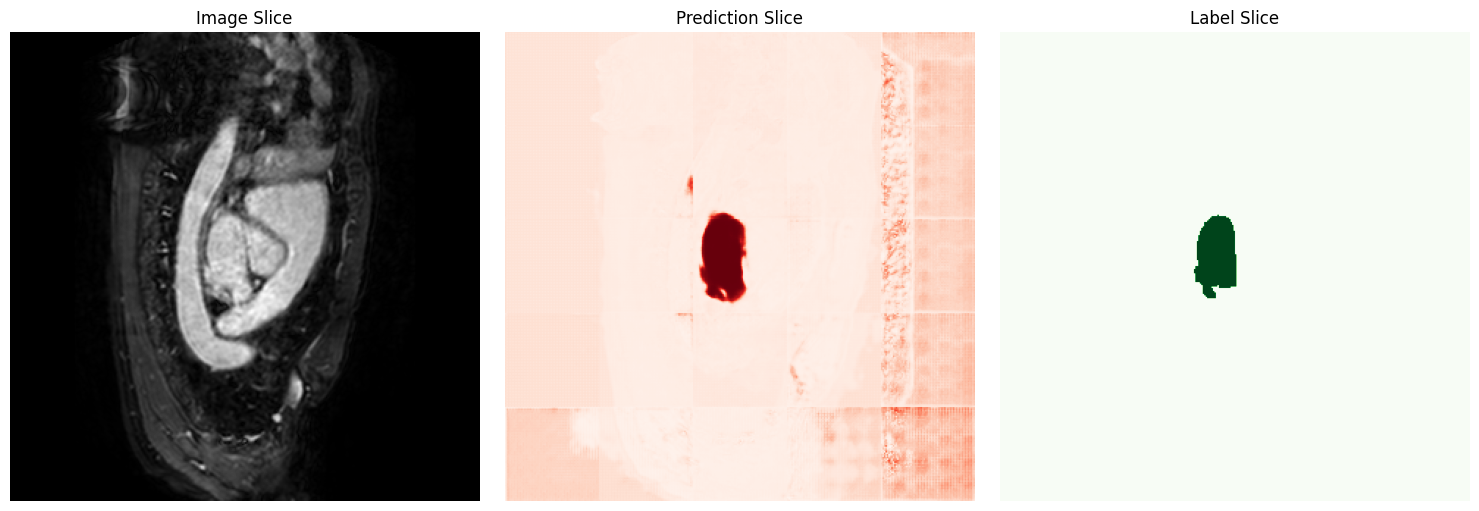

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Select the 50th slice along the first axis
slice_index = 60

image_slice = image[slice_index].cpu().numpy()
pred_slice = pred[slice_index].cpu().numpy()
label_slice = label[slice_index].cpu().numpy()

# Create the figure and the axes with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image slice
axs[0].imshow(image_slice, cmap='gray')
axs[0].set_title('Image Slice')
axs[0].axis('off')

# Plot the prediction slice
axs[1].imshow(pred_slice, vmin=0, vmax=1, cmap='Reds')
axs[1].set_title('Prediction Slice')
axs[1].axis('off')

# Plot the label slice
axs[2].imshow(label_slice, cmap='Greens')
axs[2].set_title('Label Slice')
axs[2].axis('off')

# Display the figure
plt.tight_layout()
plt.show()

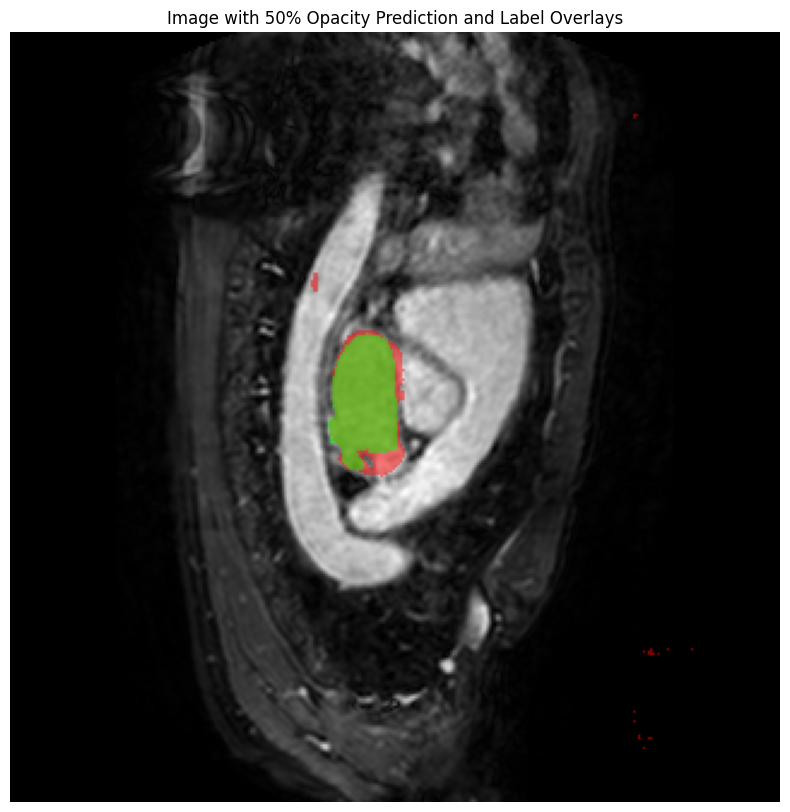

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Select the 50th slice along the first axis
slice_index = 60
image_slice = image[slice_index].cpu().numpy()
pred_slice = pred[slice_index].cpu().numpy()
label_slice = label[slice_index].cpu().numpy()

pred_slice = (pred_slice > 0.5).astype(np.float32)

# Normalize image slice for visualization (if needed)
image_slice = (image_slice - image_slice.min()) / (image_slice.max() - image_slice.min())

# Create an RGB image from the grayscale slice
image_rgb = np.stack([image_slice]*3, axis=-1)

# Create solid colors for the prediction and label overlays
red_overlay = np.zeros_like(image_rgb)
red_overlay[..., 0] = 1  # Red color for prediction

green_overlay = np.zeros_like(image_rgb)
green_overlay[..., 1] = 1  # Green color for label

# Create the prediction and label masks (expanding dims for compatibility)
pred_mask = np.expand_dims(pred_slice, axis=-1)
label_mask = np.expand_dims(label_slice, axis=-1)

# Set the opacity for the overlays (50% opacity)
opacity = 0.5

# Blend the solid color with the original image using the mask
# First, apply the red overlay for predictions
overlay_image = image_rgb * (1 - pred_mask * opacity) + red_overlay * pred_mask * opacity

# Then, apply the green overlay for labels
overlay_image = overlay_image * (1 - label_mask * opacity) + green_overlay * label_mask * opacity

# Plot the resulting image with the 50% opacity overlays
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title('Image with 50% Opacity Prediction and Label Overlays')
plt.axis('off')
plt.show()